# Installs

In [ ]:
!pip install rdkit bitarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 12.0 MB/s eta 0:00:00


# Imports

In [ ]:
from rdkit import Chem
import hashlib
from bitarray import bitarray

# Simplified ECFP Algorithm Implementation

A simplified implementation of the ECFP algorithm, it only includes the core principles of ECFP and it does not include:

*   Heavy neighbor atom invariant calculation
*   Duplicate structure removal

In [ ]:
# Helper function to flatten a list of tuples
def flatten(lst):
    return [item for sublist in lst for item in sublist]

In [ ]:
def atom_invariant(atom):
    """
    Generates a hash of atom invariants, capturing detailed properties of each atom.
    These properties help in uniquely identifying atoms based on their chemical environment.
    The hash of these properties serves as a compact identifier for the atom.
    (Note: does not include all properties covered in ECFP)

    Parameters:
    - atom: An RDKit Atom object.

    Returns:
    - A hash of a tuple containing atom properties including atomic number, total degree (bonds count including hydrogens),
      total number of hydrogens, explicit valence, atomic mass, formal charge, and ring membership.
    """
    properties = (
        atom.GetAtomicNum(),  # Atomic number, identifies the element type.
        atom.GetNumImplicitHs() + atom.GetNumExplicitHs(), # Number of attached hydrogens (both implicit and explicit)
        atom.GetExplicitValence(), # Explicit valence
        atom.GetMass(), # Atomic mass
        atom.GetFormalCharge(),  # Atom's formal charge.
        atom.IsInRing()  # Boolean indicating if the atom is part of a ring structure.
    )
    # Return the hash of the properties tuple
    return hash(properties)

In [ ]:
def get_neighborhood_hash(mol, atom_idx, iteration, previous_neighborhoods, hash_to_bonds):
    """
    Calculates a hash for the neighborhood of an atom at a given iteration depth,
    and tracks the bonds involved in that neighborhood. The hash and bond tracking
    are used to generate extended connectivity fingerprints (ECFPs).

    This function iterates over the neighbors of the specified atom, collects
    their properties and bond orders, and creates a hash representing the
    neighborhood's substructure at the current iteration. Additionally, it
    accumulates and updates the set of bonds involved for each unique neighborhood
    hash seen across iterations, supporting substructure tracking within the molecule.

    Parameters:
    - mol (RDKit Mol): The molecule being analyzed.
    - atom_idx (int): Index of the atom whose neighborhood hash is being calculated.
    - iteration (int): The current iteration depth, controlling the "radius" of
      the neighborhood being considered.
    - previous_neighborhoods (set): A set of previously encountered neighborhood
      hashes to avoid duplications.
    - hash_to_bonds (dict): A dictionary mapping unique neighborhood hashes to sets
      of bonds (as frozensets of atom indices and bond types) included in each
      neighborhood.

    Returns:
    - (tuple or None, set): A tuple containing the new neighborhood hash (or None
      if the neighborhood hash is not new) and the updated set of bonds for the
      current neighborhood. If the neighborhood hash is not new, it returns None
      instead of the hash to indicate that this particular neighborhood structure
      has been previously encountered.
    """

    ### STEP 1 - GET NEIGHBORHOOD HASH ###
    atom = mol.GetAtomWithIdx(atom_idx)
    # Start with a list containing the iteration number and the core atom's hash
    neighborhood = [(iteration, atom_invariant(atom))]
    bond_order_neighbor_pairs = []

    # Loop through neighbors and collect each neighbors bond order and hash
    for nbr in atom.GetNeighbors():
        bond = mol.GetBondBetweenAtoms(atom_idx, nbr.GetIdx())
        bond_order = bond.GetBondTypeAsDouble()
        neighbor_hash = atom_invariant(nbr)
        bond_order_neighbor_pairs.append((bond_order, neighbor_hash))

    # Sort the neighbor pairs by bond order, then by neighbor hash
    bond_order_neighbor_pairs.sort()

    # Extend the neighborhood list with the sorted neighbor information
    for pair in bond_order_neighbor_pairs:
        neighborhood.append(pair)

    # Flatten the list and convert to a tuple for hashing
    neighborhood_tuple = tuple(flatten(neighborhood))

    neighborhood_hash = hash(neighborhood_tuple)

    # Check if the neighborhood hash is new before adding it to previous_neighborhoods
    is_new_hash = neighborhood_hash not in previous_neighborhoods

    ### STEP 2 - BOND TRACKING ###
    # Initialize an empty set to accumulate bonds for the current neighborhood hash.
    accumulated_bonds = set()

    # Accumulate all bonds associated with the core atom and its neighbors from the previous iteration
    if iteration > 0:
        for prev_hash, prev_bonds in hash_to_bonds.items():
            if any(atom_idx in bond_atoms for bond_atoms, bond_type, iter_num in prev_bonds if iter_num == iteration - 1):
                accumulated_bonds.update({(bond_atoms, bond_type, iter_num) for bond_atoms, bond_type, iter_num in prev_bonds if iter_num == iteration - 1})

    # Collect bonds for tracking, using frozenset for non-directionality (in the context of molecular graphs, a bond between
    # atom 0 and atom 1 is the same as a bond between atom 1 and atom 0)
    # Each element of the bonds set is a tuple where the first element is a frozenset identifying the bond by the indices of the atoms
    # involved, and the second element is the bond type represented as a double. This allows tracking both the connectivity
    # and the type of each bond.
    for nbr in atom.GetNeighbors():
        bond = mol.GetBondBetweenAtoms(atom_idx, nbr.GetIdx())
        accumulated_bonds.add((frozenset({atom_idx, nbr.GetIdx()}), bond.GetBondTypeAsDouble(), iteration))

    ### STEP 3 - UPDATE AND RETURN ###

    # Updating ID set and initial collection of bonds for this neighborhood, if it's a new hash
    # Decide on what to return based on whether the neighborhood_hash is new
    if is_new_hash:
        # Add hash to the unique set of IDs passed in during the ecfp call
        previous_neighborhoods.add(neighborhood_hash)
        hash_to_bonds[neighborhood_hash] = accumulated_bonds
        return neighborhood_hash, accumulated_bonds
    else:
        # Update the existing entry with newly accumulated bonds
        hash_to_bonds[neighborhood_hash].update(accumulated_bonds)
        return None, accumulated_bonds

In [ ]:
def ecfp(mol, radius=2):
    """
    Computes the Extended Connectivity Fingerprint (ECFP) for a given molecule, starting with iteration 0
    for just the atom identifiers, then expanding in further iterations. Additionally, collects all unique
    identifiers generated throughout the iterations.

    Parameters:
    - mol: An RDKit Molecule object.
    - radius: The radius of neighborhoods to consider, corresponding to the iteration count.

    Returns:
    - A bitarray representing the ECFP of the molecule.
    - A list of all unique identifiers generated through all iterations.
    - A set of "tracked bonds and substructures"
    """
    fp_length = 2048  # Length of the fingerprint bitarray.
    fingerprint = bitarray(fp_length)
    fingerprint.setall(0)

    all_unique_identifiers = set()  # Set to keep track of all unique identifiers generated

    hash_to_bonds = {}  # Dictionary to map unique hashes to their bonds

    for iteration in range(0, radius + 1):
        for atom_idx in range(mol.GetNumAtoms()):
            if iteration == 0:
                # Directly use atom_invariant as the unique identifier without neighbor info
                atom_hash = atom_invariant(mol.GetAtomWithIdx(atom_idx))
                # Add to the set of unique identifiers
                all_unique_identifiers.add(atom_hash)
                # Map the atom's hash to a position in the fingerprint and set the bit
                bit_pos = int(hashlib.sha256(str(atom_hash).encode('utf-8')).hexdigest(), 16) % fp_length
                fingerprint[bit_pos] = 1
            else:
                # Include neighbor information in subsequent iterations
                neighborhood_hash, bonds = get_neighborhood_hash(mol, atom_idx, iteration, all_unique_identifiers, hash_to_bonds)
                # print(neighborhood_hash)
                if neighborhood_hash is not None:
                    # Add to the set of unique identifiers
                    all_unique_identifiers.add(neighborhood_hash)
                    # Store the bonds for this unique hash
                    hash_to_bonds[neighborhood_hash] = bonds
                    # Map the hash to a position in the fingerprint and set the bit
                    bit_pos = int(hashlib.sha256(str(neighborhood_hash).encode('utf-8')).hexdigest(), 16) % fp_length
                    fingerprint[bit_pos] = 1

    # Convert the set of all unique identifiers to a list
    unique_identifiers_list = list(all_unique_identifiers)

    return fingerprint, unique_identifiers_list, hash_to_bonds

In [ ]:
# Example using butyramide
smiles = 'CCCC(=O)N'
mol = Chem.MolFromSmiles(smiles)

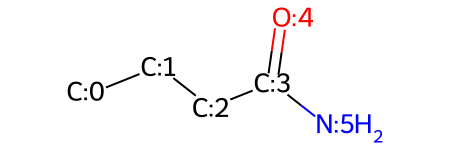

In [ ]:
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

mol

In [ ]:
fingerprint, ids, bond_tracking = ecfp(mol, radius=3)

In [ ]:
fingerprint.count(True)

23

In [ ]:
ids

[-3142884425696203389,
 -1121946347898195580,
 111745456641953158,
 6840591145590741013,
 2493798636631523240,
 3880773608838887209,
 2825146501274315050,
 5265173628904811564,
 8266629056374881708,
 553546502487514672,
 6153815791553408174,
 699118068866822964,
 -2639042515101471426,
 3529725126632241089,
 -2849386149984538425,
 -1974585728107678129,
 932545384902316631,
 -1407193365571786532,
 -729676255114090913,
 -7393798148930274194,
 -6939244301963675531,
 18844545212354163,
 6233139277601181429]

In [ ]:
len(bond_tracking)

18

In [ ]:
bond_tracking

{-1407193365571786532: {(frozenset({0, 1}), 1.0, 1)},
 932545384902316631: {(frozenset({1, 2}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 1)},
 2825146501274315050: {(frozenset({2, 3}), 1.0, 1),
  (frozenset({1, 2}), 1.0, 1)},
 -2849386149984538425: {(frozenset({2, 3}), 1.0, 1),
  (frozenset({3, 4}), 2.0, 1),
  (frozenset({3, 5}), 1.0, 1)},
 6840591145590741013: {(frozenset({3, 4}), 2.0, 1)},
 -2639042515101471426: {(frozenset({3, 5}), 1.0, 1)},
 18844545212354163: {(frozenset({1, 2}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 2)},
 5265173628904811564: {(frozenset({1, 2}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 1),
  (frozenset({1, 2}), 1.0, 2),
  (frozenset({2, 3}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 2)},
 111745456641953158: {(frozenset({3, 4}), 2.0, 1),
  (frozenset({3, 5}), 1.0, 1),
  (frozenset({1, 2}), 1.0, 1),
  (frozenset({0, 1}), 1.0, 1),
  (frozenset({1, 2}), 1.0, 2),
  (frozenset({2, 3}), 1.0, 1),
  (frozenset({2, 3}), 1.0, 2)},
 -7393798148930274194: {(fro

In [ ]:
# Initialize a list to keep track of the reduced sets (each containing only the first two elements of the original tuples)
# This is for inspecting unique sets based on the first two elements of the tuples: atoms and bonds (ignoring iteration)
reduced_sets = []

for bond_set in bond_tracking.values():
    # Use a set comprehension to create a set of 2-element tuples from the 3-element tuples
    reduced_set = {(frozenset(bond_atoms), bond_type) for bond_atoms, bond_type, _ in bond_set}
    if reduced_set not in reduced_sets:
        reduced_sets.append(reduced_set)

In [ ]:
len(reduced_sets)

8

In [ ]:
reduced_sets

[{(frozenset({0, 1}), 1.0)},
 {(frozenset({0, 1}), 1.0), (frozenset({1, 2}), 1.0)},
 {(frozenset({1, 2}), 1.0), (frozenset({2, 3}), 1.0)},
 {(frozenset({3, 4}), 2.0),
  (frozenset({3, 5}), 1.0),
  (frozenset({2, 3}), 1.0)},
 {(frozenset({3, 4}), 2.0)},
 {(frozenset({3, 5}), 1.0)},
 {(frozenset({0, 1}), 1.0),
  (frozenset({1, 2}), 1.0),
  (frozenset({2, 3}), 1.0)},
 {(frozenset({2, 3}), 1.0),
  (frozenset({3, 5}), 1.0),
  (frozenset({0, 1}), 1.0),
  (frozenset({1, 2}), 1.0),
  (frozenset({3, 4}), 2.0)}]

# RDKit Implementation

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, AllChem
import numpy as np

def ecfp_from_smiles(smiles, radius=3, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    # Convert the RDKit explicit bit vector to a Numpy array for easier use
    np_fp = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, np_fp)
    return np_fp

In [ ]:
smiles_string = 'CCCC(=O)N'
fingerprint = ecfp_from_smiles(smiles_string)
print(fingerprint)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
sum(fingerprint)

14.0

From RDKit Docs:

"The fingerprint generators can collect information about the atoms/bonds involved in setting bits when a fingerprint is generated. This information is quite useful for understanding which parts of a molecule were involved in each bit.

Each fingerprinting method provides different information, but this is all accessed using the additionalOutput argument to the fingerprinting functions.

Information is available about the atoms that contribute to particular bits in the Morgan fingerprint via the bit info map. This is a dictionary with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples."

https://rdkit.org/docs/GettingStartedInPython.html#explaining-bits-from-morgan-fingerprints


In [ ]:
m = Chem.MolFromSmiles('CCCC(=O)N')
fpgen = AllChem.GetMorganGenerator(radius=3)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetSparseCountFingerprint(m,additionalOutput=ao)
print(len(fp.GetNonzeroElements()))
info = ao.GetBitInfoMap()
print(len(info))

14
14


In [ ]:
info

{474023245: ((1, 2),),
 847957139: ((5, 0),),
 864942730: ((4, 0),),
 1167322652: ((2, 1),),
 1173125914: ((1, 1),),
 1510328189: ((4, 1),),
 2231929377: ((3, 2),),
 2245384272: ((1, 0), (2, 0)),
 2246699815: ((3, 0),),
 2246728737: ((0, 0),),
 2591432844: ((5, 1),),
 3328145258: ((3, 1),),
 3542456614: ((0, 1),),
 4112692162: ((2, 2),)}

Interpreting the above: bit 2245384272 is set twice: once by atom 1 and once by atom 2, each at radius 0. Bit 2591432844 is set once by atom 5 at radius 1.

Focusing on bit 2591432844, we can extract the submolecule consisting of all atoms within a radius of 1 of atom 5:

In [ ]:
env = Chem.FindAtomEnvironmentOfRadiusN(m,1,5)
amap={}
submol=Chem.PathToSubmol(m,env,atomMap=amap)
submol.GetNumAtoms()
amap

{3: 0, 5: 1}

In [ ]:
Chem.MolToSmiles(submol)

'CN'

In [ ]:
# This is more useful when the SMILES is rooted at the central atom:
Chem.MolToSmiles(submol,rootedAtAtom=amap[5],canonical=False)

'NC'